In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import util
from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Conv2DTranspose
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import platform
import time
import os

In [2]:
def get_unet(input_img, num_class, start_neurons=64, dropout=0.1 ):
    inputs = keras.Input(shape=input_img)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(inputs)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(dropout)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(dropout)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(dropout)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(dropout)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)

    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(dropout)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(dropout)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    output_layer = Conv2D(num_class, (1, 1), padding="same", activation="sigmoid")(uconv1)

    model = Model(inputs, output_layer)
    return model

In [3]:
def train(x_train, y_train, x_val, y_val, image_shape, classes, epoch, batchSize, modelName):
    model = get_unet(image_shape, num_class=classes)
    print(model.summary())
    model.compile(optimizer=Adam(learning_rate=.0001), loss="sparse_categorical_crossentropy", metrics=['accuracy'], )

    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

    history = model.fit(x=x_train, y=y_train, epochs=epoch, validation_data=(x_val, y_val), batch_size=batchSize,
                        callbacks=[earlyStopping])
    
    if not os.path.isdir(pathModel):  # 没有save_dir对应目录则建立
        os.makedirs(pathModel)
    
    model.save(pathModel +modelName)

    df = pd.DataFrame({'accuracy': history.history['accuracy'],
                       'val_accuracy': history.history['val_accuracy'],
                       'loss': history.history['loss'],
                       'val_loss': history.history['val_loss']})
    df.to_csv(pathOutput+'unetd3.csv', index=False)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')
    plt.show()

In [4]:
def predict(path_model, x_test, y_test):
    model =keras.models.load_model(path_model)
    val_predicts = model.predict(x_test)
    util.output(pathOutput + 'c3mask.png', y_test[0])
    util.output(pathOutput + 'c3mask1.png', y_test[1])
    util.output(pathOutput + 'c3predicted.png', val_predicts[0] * 64)
    util.output(pathOutput + 'c3predicted1.png', val_predicts[1] * 64)
    util.output(pathOutput + 'c3predicted3.png', val_predicts[0])
    util.output(pathOutput + 'c3predicted4.png', val_predicts[1])
    util.output(pathOutput + 'c3ori.png', x_test[0] * 255)
    util.output(pathOutput + 'c3ori1.png', x_test[1] * 255)
    return val_predicts

In [5]:

def labelVisualize(predicted, masks):
    result = []
    f, axarr = plt.subplots(2, 2)
    for counter,img in enumerate(predicted):
        imgOut = np.argmax(img, axis=-1)
        axarr[counter, 0].set_title('Ground Truth '+str(counter))
        axarr[counter, 0].imshow(masks[counter])
        axarr[counter, 0].set_axis_off()
        axarr[counter, 1].set_title('Predicted Mask '+str(counter))
        axarr[counter, 1].imshow(imgOut)
        axarr[counter, 1].set_axis_off()
        result.append(imgOut)
    plt.show()

    return result


In [6]:
def overlay(img, mask):

    img_before = cv2.merge((mask, mask, mask))
    img_before[img_before[:, :, 0] ==1, 0] = 0
    img_before[img_before[:, :, 1] ==1, 1] = 0
    img_before[img_before[:, :, 2] ==1, 2] = 255
    img_before[img_before[:, :, 0] ==2, 0] = 0
    img_before[img_before[:, :, 1] ==2, 1] = 255
    img_before[img_before[:, :, 2] ==2, 2] = 0
    img_before[img_before[:, :, 0] ==3, 0] = 0
    img_before[img_before[:, :, 1] ==3, 1] = 255
    img_before[img_before[:, :, 2] ==3, 2] = 255

    blendBefore = cv2.addWeighted(img_before.astype('float64'),  0.2, img, 0.6,0)

    return blendBefore


In [7]:
def get_file_path(root_path, file_list=[], dir_list=[]):
    # 获取该目录下所有的文件名称和目录名称
    dir_or_files = os.listdir(root_path)
    for dir_file in dir_or_files:
        # 获取目录或者文件的路径
        dir_file_path = os.path.join(root_path, dir_file)
        # 判断该路径为文件还是路径
        if os.path.isdir(dir_file_path):
            dir_list.append(dir_file_path)
            # 递归获取所有文件和目录的路径
            get_file_path(dir_file_path, file_list, dir_list)
        else:
            file_list.append(dir_file_path)
    return file_list, dir_list

In [8]:
def getData(path):
    file_list, dir_list = get_file_path(path)
    images = []
    masks = []
    for file in file_list:
        if "jpg" in file:
            image = cv2.imread(file)
            np_file = file.replace('JPEGImages', 'SegmentationClass')
            np_file = np_file.replace('jpg', 'npy')
            mask =  np.load(np_file)
            images.append(image)
            masks.append(mask)
    return images, masks

In [9]:
def getNpData():
    
    dirs_img = os.listdir('/home/aoi3080/Yanqin/dataset/semantic_dataset/data_dataset_voc/JPEGImages/')
    path_img = '/home/aoi3080/Yanqin/dataset/semantic_dataset/data_dataset_voc/JPEGImages/'
    path_mask = '/home/aoi3080/Yanqin/dataset/semantic_dataset/data_dataset_voc/SegmentationClass/'

    (images, masks) = util.unetPrepro(dirs_img,path_img,path_mask)

    np.save('/home/aoi3080/Yanqin/dataset/semantic_dataset/input/imagesDirty3.npy', np.array(images))
    np.save('/home/aoi3080/Yanqin/dataset/semantic_dataset/input/masksDirty3.npy', masks)

In [10]:
keras.backend.clear_session()

# 改变数据/模型/输出->路径

DATADIR = "/home/aoi3080/Yanqin/dataset/fabric_use/"
pathInput = '/home/aoi3080/Yanqin/dataset/semantic_dataset/input/'
pathOutput = '/home/aoi3080/Yanqin/dataset/semantic_dataset/output/'
pathModel = '/home/aoi3080/Yanqin/dataset/semantic_dataset/model/'

date = time.strftime("%Y%m%d_%H_%M", time.localtime()) + '/'

if platform.node() == 'niyanqindeMacBook-Pro.local':
    
    DATADIR = "/Users/niyanqin/PycharmProjects/LearningDL/dataset/fabric_use/"

    pathInput = '/Users/niyanqin/PycharmProjects/LearningDL/dataset/semantic_dataset/input/'
    pathOutput = '/Users/niyanqin/PycharmProjects/LearningDL/dataset/semantic_dataset/output/'
    pathModel = '/Users/niyanqin/PycharmProjects/LearningDL/dataset/semantic_dataset/model/'



imageShape = [848, 1056, 3]
numClasses = 4
epoch = 50
batchSize = 1

x = np.load(pathInput + 'imagesDirty3.npy', allow_pickle=True)
y = np.load(pathInput + 'masksDirty3.npy', allow_pickle=True)
x_train = x[:10]
y_train = y[:10]
x_val = x[10:13]
y_val = y[10:13]
x_test = x[13:]
y_test = y[13:]

# x_train = x[:7]
# y_train = y[:7]
# x_val = x[7:10]
# y_val = y[7:10]
# x_test = x[10:]
# y_test = y[10:]
back_img= np.zeros((848, 1056))
mask = np.divide(y_test[0], 3)
img_before = overlay(x_test[0]*255, y_test[0])



In [12]:
model = get_unet(imageShape, num_class=numClasses)
print(model.summary())
model.compile(optimizer=Adam(learning_rate=.0001), loss="sparse_categorical_crossentropy", metrics=['accuracy'], )

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

history = model.fit(x=x_train, y=y_train, epochs=epoch, validation_data=(x_val, y_val), batch_size=batchSize,
                    callbacks=[earlyStopping])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 848, 1056, 3 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 848, 1056, 64 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 848, 1056, 64 36928       conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 424, 528, 64) 0           conv2d_20[0][0]                  
____________________________________________________________________________________________

10/10 [==============================] - 141s 14s/sample - loss: 1.3515 - accuracy: 0.4610 - val_loss: 1.2976 - val_accuracy: 0.4580
Epoch 2/50
10/10 [==============================] - 140s 14s/sample - loss: 1.1684 - accuracy: 0.4584 - val_loss: 1.0839 - val_accuracy: 0.4580
Epoch 3/50
10/10 [==============================] - 140s 14s/sample - loss: 1.0443 - accuracy: 0.4584 - val_loss: 1.0053 - val_accuracy: 0.4580
Epoch 4/50
10/10 [==============================] - 142s 14s/sample - loss: 0.9804 - accuracy: 0.4592 - val_loss: 1.1050 - val_accuracy: 0.4671
Epoch 5/50
10/10 [==============================] - 142s 14s/sample - loss: 0.9027 - accuracy: 0.5303 - val_loss: 0.8418 - val_accuracy: 0.6492
Epoch 6/50
10/10 [==============================] - 142s 14s/sample - loss: 0.7152 - accuracy: 0.8168 - val_loss: 0.4487 - val_accuracy: 0.8929
Epoch 7/50
10/10 [==============================] - 142s 14s/sample - loss: 0.2831 - accuracy: 0.9035 - val_loss: 0.2351 - val_accuracy: 0.9028
Epo

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/aoi3080/Yanqin/dataset/semantic_dataset/model/unetd3/assets


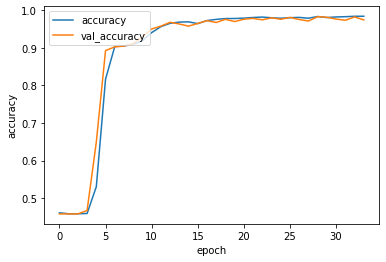

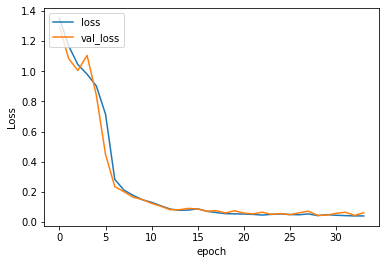

In [13]:

if not os.path.isdir(pathModel):  # 没有save_dir对应目录则建立
    os.makedirs(pathModel)

model.save(pathModel + 'unetd3')

df = pd.DataFrame({'accuracy': history.history['accuracy'],
                   'val_accuracy': history.history['val_accuracy'],
                   'loss': history.history['loss'],
                   'val_loss': history.history['val_loss']})
df.to_csv(pathOutput+'unetd3.csv', index=False)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

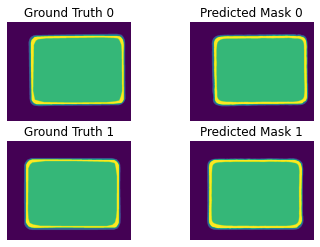

In [16]:
val_predicts = model.predict(x_test)
predicted_mask = labelVisualize(val_predicts, y_test)
for counter, value in enumerate(predicted_mask):
    before = overlay(x_test[counter] * 255, y_test[counter])
    after = overlay(x_test[counter] * 255, value)
    util.output(pathOutput + date + 'overlayBefore'+str(counter)+'.png', before)
    util.output(pathOutput + date + 'overlayAfter'+str(counter)+'.png', after)


In [17]:
x_predicts = model.predict(x)

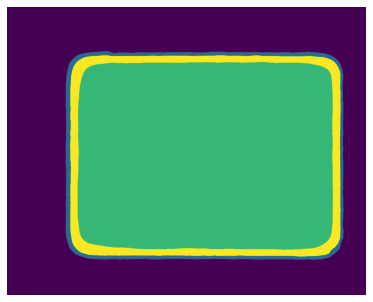

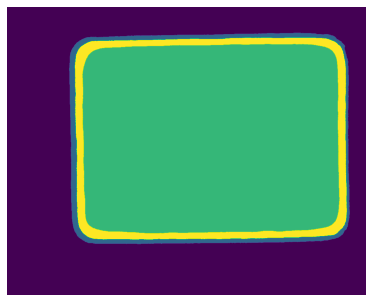

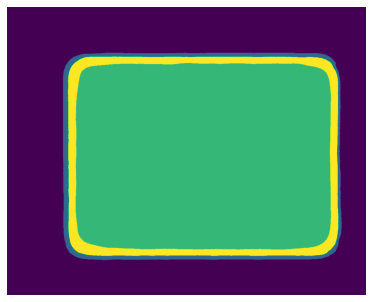

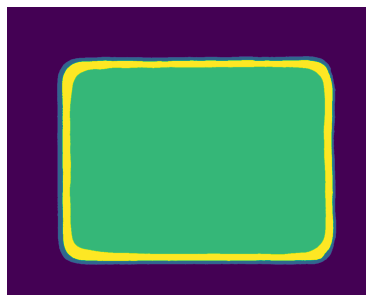

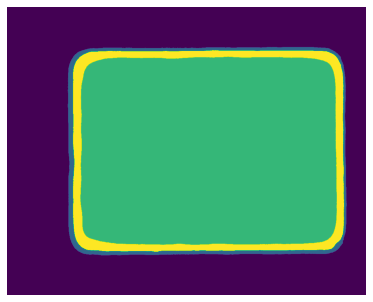

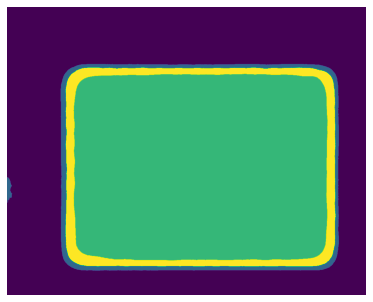

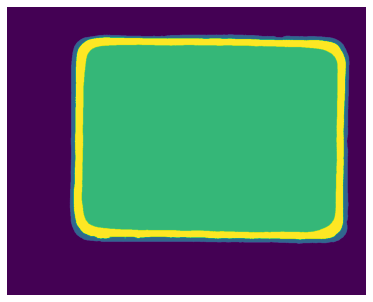

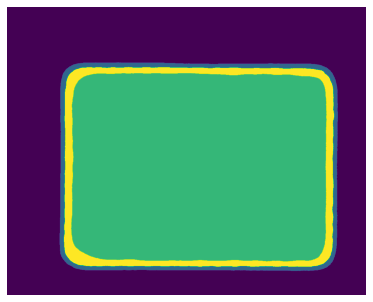

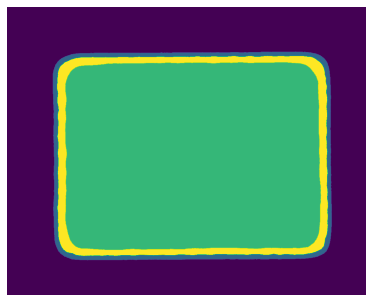

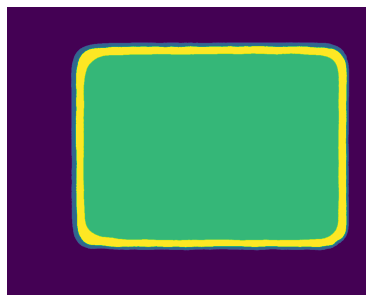

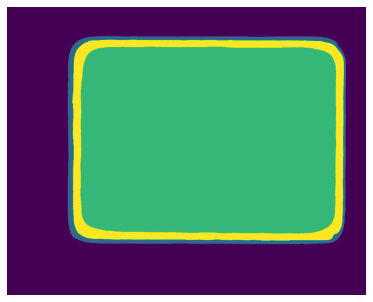

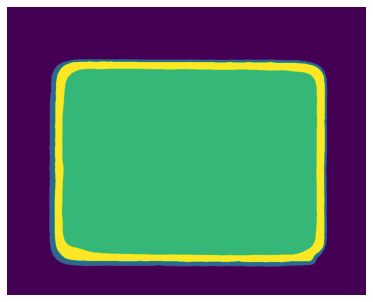

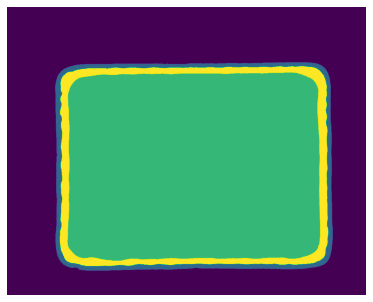

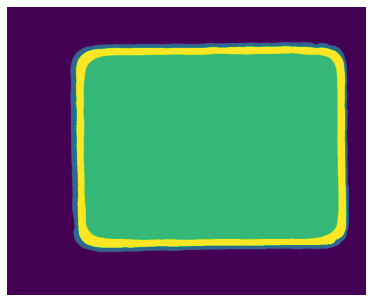

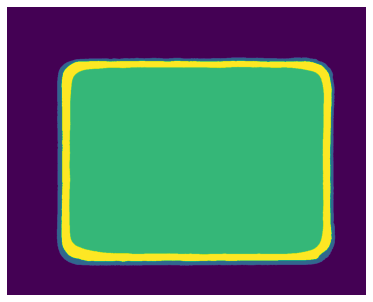

In [120]:
result = []

result_np = []
for counter,img in enumerate(x_predicts):
    imgOut = np.argmax(img, axis=-1)
    plt.imshow(imgOut)
    plt.axis('off')
    fig.set_size_inches(10.56/6,8.48/6) #dpi = 600, output = 1056 * 848 pixels
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0,0)
    fig.savefig(pathOutput + 'predict/' + str(counter) + '_tr.jpg', format='jpg', transparent=True, dpi=600, pad_inches = 0)
    plt.show()
    result.append(imgOut)
    
    image = cv2.imread(pathOutput + 'predict/' + str(counter) + '_tr.jpg')
    result_np.append(image)
    
np.save(pathOutput+ 'predict.npy', result)
np.save(pathOutput+ 'predictd3.npy', result_np)